In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import fmin_ncg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
W = np.load('../rnndata/weight_hh_l0.npy')
b = np.load('../rnndata/bias_hh_l0.npy')
bi = np.load('../rnndata/bias_ih_l0.npy')

N = W.shape[0]

def f(x):
    r = np.tanh(W@x+b+bi)
    dx = -x+r
    return 0.5*(dx.T@dx)

## optimization functions / helpers
def f(x):
#     r = np.tanh(x)
#     dx = -x+W@r
    r = np.tanh(W@x+b+bi)
    dx = -x+r
    return 0.5*(dx.T@dx)

def grad_f(x):
#     r = np.tanh(x)
#     dx = -x+W@r
    r = np.tanh(W@x+b+bi)
    dx = -x+r
    d1 = (1-np.power(r,2)).reshape(N,1)
    h = ((W.T * (d1@np.ones([1,N]))) - np.identity(N))
    return h@dx

def hess_f(x):
#     r = np.tanh(x)
#     dx = -x+W@r
    r = np.tanh(W@x+b+bi)
    dx = -x+r
    d1 = (1-np.power(r,2)).reshape(N,1)
    h = ((W.T * (d1@np.ones([1,N]))) - np.identity(N))
    return h@h.T

## projection function with SVD
def PCA_project(X, modes, plot_SVs=True):
    # SVD of X
    U, s, VT = np.linalg.svd(X)
    
    # construct S matrix with S_vector -- there must be a better way to do this?
    S = np.zeros([U.shape[0],VT.shape[0]])
    for i in range(modes):
        S[i,i] = s[i]

#     print("shapes", X.shape, U.shape,S.shape,VT[:,:modes].shape, (U@S@VT[:,:modes]).shape)
    if plot_SVs:
        plt.plot(np.log(s))
        plt.show()
    return U@S@VT[:,:modes]

In [4]:
trajectory = pd.read_csv('../rnndata/worldtour.csv', header=None).values.T
## get trajectories
# traj0 = np.loadtxt(open("../rnndata/0perturb.csv", "rb"), delimiter=",", skiprows=1).T
# traj1 = np.loadtxt(open("../rnndata/1perturb.csv", "rb"), delimiter=",", skiprows=1).T
# traj2 = np.loadtxt(open("../rnndata/2perturb.csv", "rb"), delimiter=",", skiprows=1).T

# datasets = [traj0.T,traj1.T,traj2.T]
# n_dsets = len(datasets)
# traj_c = np.concatenate(datasets).T

trajectory_p = PCA_project(trajectory.T,3)

plt.figure(1)

# traj_projected_split = np.split(traj_projected,n_dsets)
# for i in range(len(traj_projected_split)):
#     plt.subplot(311+i)
#     for traj in traj_projected_split[i].T:
#         plt.plot(np.arange(traj.shape[0]), traj)

for traj in trajectory_p.T:
    plt.plot(np.arange(traj.shape[0]), traj)

plt.show()

In [7]:
trajectory_p.shape

(320, 3)

In [8]:
## use trajectories to find nearby fixed pts
# xs = traj_c
xopts = []
for x in trajectory.T:
    xopt = fmin_ncg(f, x, grad_f, fhess=hess_f, avextol=1e-10)
    xopts.append(xopt)
    
xopts = np.array(xopts)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 37
         Hessian evaluations: 17
         Current function value: 0.021818
         Iterations: 3
         Function evaluations: 45
         Gradient evaluations: 36
         Hessian evaluations: 4
         Current function value: 0.010717
         Iterations: 5
         Function evaluations: 28
         Gradient evaluations: 21
         Hessian evaluations: 6
         Current function value: 0.004821
         Iterations: 4
         Function evaluations: 27
         Gradient evaluations: 19
         Hessian evaluations: 5
         Current function value: 0.002041
         Iterations: 3
         Function evaluations:

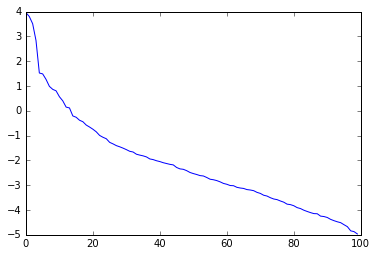

shapes: (320, 3) (320, 3)


In [9]:
## concatenate trajectories and fixed points, project into 3D, and separate
divide = trajectory.shape[1]
concat=np.hstack([trajectory,xopts.T])
proj_concat = PCA_project(concat.T,3)
trajectory_p = proj_concat[:divide]
# traj_projected_split = np.split(traj_projected,3)
xopts_p = proj_concat[divide:]
print('shapes:', trajectory_p.shape, xopts_p.shape)

## alternately, SVD traj_c and project fixed points accordingly. ## not sure this is correct.
# U, s, VT = np.linalg.svd(traj_c)
# modes = 3

# S = np.zeros([U.shape[0],VT.shape[0]])
# for i in range(modes):
#     S[i,i] = s[i]

# xopts_projected2 = (U.T[:3,:]@xopts.T).T/s[:3]

In [12]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import random
plotly.tools.set_credentials_file(username='elbertgong', api_key='••••••••••')

In [17]:


r = lambda: random.randint(0,255)
color = '#%02X%02X%02X' % (r(),r(),r())

# fixed points projected by U of trajectories
x = pd.Series(xopts_p[:,0])
y = pd.Series(xopts_p[:,1])
z = pd.Series(xopts_p[:,2])

fps = go.Scatter3d(x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.3
    )
)

color = '#%02X%02X%02X' % (r(),r(),r())

x = pd.Series(trajectory_p[:,0])
y = pd.Series(trajectory_p[:,1])
z = pd.Series(trajectory_p[:,2])

trace = go.Scatter3d(x=x, y=y, z=z,
    marker=dict(
        size=4,
        color=color,
        colorscale='Viridis',
    ),
    line=dict(
        color=color,
        width=1
    )
)

data = [fps,trace]
    
layout = dict(
    width=800,
    height=700,
    autosize=True,
    title='3 bit flip flop',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig = dict(data=data, layout=layout)

# plotly.offline.iplot(fig, filename='3bit_fps_plz')#, height=700, validate=False)
plot(fig)

NameError: name 'plot' is not defined

In [28]:
# init_notebook_mode(connected=True)
from plotly.graph_objs import *
plotly.offline.plot(fig, filename='3bit_fps_plz')#, height=700, validate=False)
# plot(fig)

C:\Users\owner\Anaconda3\lib\site-packages\plotly\offline\offline.py:459: UserWarning:

Your filename `3bit_fps_plz` didn't end with .html. Adding .html to the end of your file.



'file://C:\\Users\\owner\\Desktop\\Spring18\\am108-final-project\\sussillo\\3bit_fps_plz.html'

In [25]:
x

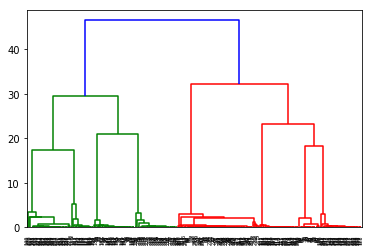

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# number of clusters
k = 7

# computes the distance between points, merges closest based on the method
Z=linkage(xopts, method='ward');

# draws the resulting dendrogram from the clustering done by linkage
dendrogram(Z);
plt.show()
# gives the cluster that each original point belongs to.
idx = fcluster(Z,k,'maxclust');

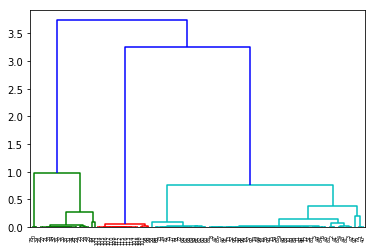

In [34]:
Z=linkage(xopts_projected, method='ward');

# draws the resulting dendrogram from the clustering done by linkage
dendrogram(Z);
plt.show()